<a href="https://colab.research.google.com/github/yanmingl/NaturalLanguageProcessing/blob/master/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Packages

In [ ]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import numpy as np
from scipy.spatial import distance
import json


# !pip install tensorflow==2.9.1 tensorflow_datasets==4.6.0
from time import time
import tensorflow as tf
import tensorflow_datasets as tfds
tf.keras.utils.set_random_seed(1234)


import nltk
from nltk import word_tokenize
from nltk.util import ngrams
nltk.download('punkt')

import spacy
# !python -m spacy download en_core_web_lg

# !pip install textdistance
# import textdistance

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print(torch.__version__)

1.13.1+cu116


## Define Path for Data and Save

In [ ]:
# Load the processed question and answer pairs from the google drive
## Mount on google drive
from google.colab import drive
drive.mount('/content/drive/')
folder_path = 'drive/MyDrive/Thesis/Performance_Comparison/'

Mounted at /content/drive/


## Data Loading

In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

corpus_name = "dailydialog"   # 'movie-corpus'
corpus = os.path.join("data", corpus_name)


def print_lines(file, n=10):
    with open(file, 'r', encoding="utf-8") as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

# Splits each line of the file into a dictionary of fields


def load_lines(file_name, type):
    if type == 'dailyDialog':
        conversations = []
        with open(file_name, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split("__eou__")
                conversations.append(values)
    else:  # for movie-corpus
        conversations = {}
        with open(file_name, 'r', encoding='utf-8') as f:
            for line in f:
                lineJson = json.loads(line)  # json string to dic
                lineObj = {}
                lineObj['text'] = lineJson['text']

                if lineJson['conversation_id'] not in conversations:
                    convObj = {}
                    convObj['conversation_id'] = lineJson['conversation_id']
                    convObj['lines'] = [lineObj]
                else:
                    convObj = conversations[lineJson['conversation_id']]
                    convObj['lines'].insert(0, lineObj)
                conversations[convObj['conversation_id']] = convObj
    return conversations  # list and dic


# Extracts pairs of sentences from conversations
def extract_sentence_pairs(conversations, type):
    qa_pairs = []
    if type == 'dailyDialog':
        for conversation in conversations:
            # Iterate over all the lines of the conversation
            # We ignore the last line (no answer for it)
            for i in range(len(conversation) - 1):
                input_line = conversation[i].strip()
                target_line = conversation[i+1].strip()
                # Filter wrong samples (if one of the lists is empty)
                if input_line and target_line:
                    qa_pairs.append([input_line, target_line])
    else:
        for conversation in conversations.values():
            for i in range(len(conversation['lines'])-1):
                input_line = conversation['lines'][i]['text']
                output_line = conversation['lines'][i+1]['text']
                if input_line and output_line:
                    qa_pairs.append([input_line, output_line])
    return qa_pairs


def create_formatted_dataset(source, target, type=None):
    # Define path to new file
    datafile = target

    delimiter = '\t'
    # Unescape the delimiter
    delimiter = str(codecs.decode(delimiter, "unicode_escape"))

    print("\nLoading conversations...")
    conversations = load_lines(source, type)

    # Write new csv file
    print("\nWriting newly formatted file...")
    with open(datafile, 'w', encoding='utf-8') as outputfile:
        writer = csv.writer(outputfile, delimiter=delimiter,
                            lineterminator='\n')
        for pair in extract_sentence_pairs(conversations, type):
            writer.writerow(pair)

    # Print a sample of lines
    print("\nSample lines from file:")
    print_lines(datafile)


def data_loading():
    types = ['dailyDialog', 'movie-corpus']
    formatted_name = 'formatted_dialogues_train.txt'
    for type in types:
        type_path = os.path.join(folder_path, 'data', type, 'train')
        if type == 'dailyDialog':
            source = os.path.join(type_path, 'dialogues_train.txt')
            target = os.path.join(type_path, formatted_name)
        else:
            source = os.path.join(type_path, 'utterances.jsonl')
            target = os.path.join(type_path, 'formatted_dialogues_train_total.txt')
        create_formatted_dataset(source, target, type)

# data_loading()

For movie corpus 

In [ ]:
def split_moive_corpus():
  # Define the path
  data_path = os.path.join(folder_path, 'data')
  corpus_path = os.path.join(data_path, 'movie-corpus')
  data_file = 'formatted_dialogues_train_total.txt'
  data_path = os.path.join(corpus_path, 'train', data_file)
  modes = ['train', 'validation', 'test']
  # Open the data file
  with open(data_path, 'r') as f:
    lines = f.readlines()
  # print(lines[:10], '\n', f'length:{len(lines)}')
  # Split them into three parts, train, validation, test
  train_size, validate_size, test_size = 76053, 7069, 6740
  random.shuffle(lines)
  # print(lines)
  train_line = lines[:train_size]
  validate_line = lines[train_size:train_size+validate_size]
  test_line = lines[-test_size:]
  # print(f'train_len:{len(train_line)}, validate_len:{len(validate_size)}, test_len:{len(test_line)}')
  # Save each part into three files
  for mode in modes:
    mode_path = os.path.join(corpus_path, mode)
    if os.path.exists(mode_path):
      pass
    else:
     os.mkdir(mode_path)
    file_path = os.path.join(mode_path, f'formatted_dialogues_{mode}.txt')
    with open(file_path, 'w') as f:
      if mode == 'train':
        f.writelines(train_line)
      elif mode == 'validation':
        f.writelines(validate_line)
      else:
        f.writelines(test_line)
# split_moive_corpus()

## Data Processing for Models

In [ ]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

# Define dull responses
DULL_RESPONSES = ["I do not know what you are talking about.", "I do not know.", "You do not know.",
                  "You know what I mean.", "I know what you mean.", "You know what I am saying.",
                  "You do not know anything."]


class Voc:
    """ Class for vocabulary
    which maintains the voc-index, index-voc, voc-count mapping dictionary, # words for instances with different names"""

    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD",
                           SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def add_sentence(self, sentence):
        """ Add sentence for mapping dictionary """
        for word in sentence.split(' '):
            self.add_word(word)  # top-bottom

    def add_word(self, word):
        """ Add word for mapping dictionary """
        if word not in self.word2index:  # start from the opposite case in general
            # update word-index, count, index-word dic and num_words
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # update word-count
            self.word2count[word] += 1

    def trim(self, min_count):
        """ Remove words below a certain count threshold and reinitialize voc instances """
        if self.trimmed:  # if trimmed, would not trim again if not initializing a new voc object
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(
                keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        # Be attention that the word2count will be false but we have trimmed the pairs and no longer use voc.word2count
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD",
                           SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count default tokens

        for word in keep_words:
            self.add_word(word)


# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalize_string(s):
    """normalize input string and return it"""

    # Convert encoding style for efficiency
    s = unicode_to_ascii(s.lower().strip())  # lowercase, strip sentences

    # Put a space in front of the final punctuation for further index
    s = re.sub(r"([.!?])", r" \1", s)

    # Remove characters except letters and the final punctuation
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)

    # Change multi-spaces into one space and strip
    s = re.sub(r"\s+", r" ", s).strip()

    return s


def load_normalize_pairs(datafile, corpus_name):
    """ Read datafile, do processing for pairs format, and return it and voc object for word-index mapping"""

    # Read the file and split into lines
    print("Reading lines...")
    lines = open(datafile, encoding='utf-8'). \
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    return pairs


def filter_pair(p, max_length=15):
    """ Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold """
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < max_length and len(p[1].split(' ')) < max_length


def filter_pairs(pairs, max_length):
    """ Filter pairs using filterPair condition """
    return [pair for pair in pairs if filter_pair(pair, max_length)]  # list of lists


def trim_rare_words(voc, pairs, min_count=3):
    """ Trim pairs with rare words under the MIN_COUNT from the voc """
    # Trim words under min_count times
    voc.trim(min_count)

    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True

        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break

        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(
        len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))

    return keep_pairs


def load_prepare_data(corpus_name, datafile, max_length, min_count, reverse):
    """Load data, do preprocessing, and return a populated voc object and pairs list"""

    print("Start preparing data ...")

    # Read datafile, do normalization, and return pair
    pairs = load_normalize_pairs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    print("pairs:")  # for evaluation
    for pair in pairs[:10]:
        print(pair)

    # Filter out pairs with long sentences
    pairs = filter_pairs(pairs, max_length)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))


    voc = Voc(corpus_name)  # Create Voc instance and update it
    for pair in pairs:
        voc.add_sentence(pair[0])
        voc.add_sentence(pair[1])
    for d in DULL_RESPONSES:  # also convert dull response
        voc.add_sentence(d)
    print("Counting words...")
    print("Counted words:", voc.num_words)  # print the final # words

    # Trim pair with rare words
    pairs = trim_rare_words(voc, pairs, min_count)

    # Reverse pairs if required
    if reverse:
        pairs = [list(reversed(pair)) for pair in pairs]

    return voc, pairs


def indexes_from_sentence(voc, sentence, trans_style=False):
    """ Return indexes list including EOS token for the sentence"""
    if trans_style:
      index = [SOS_token] + \
      [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]
    else:
      index = [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]
    return index


def zero_padding(l, fillvalue=PAD_token):
    """ Pad each element in l to the max_length of among elements with the PAD_token"""

    return list(itertools.zip_longest(*l, fillvalue=fillvalue))


def binary_matrix(l, value=PAD_token):
    """ Get mask of a list of padded lists"""

    m = []  # for mask
    for i, seq in enumerate(l):  # loop each sentence list
        m.append([])  # add a new list in m
        for token in seq:  # loop each token in the sequence
            if token == PAD_token:
                m[i].append(0)  # add 0 at the current ith list in m
            else:
                m[i].append(1)  # add 1

    return m


def input_var(l, voc):
    """ Return padded input index sequences tensor and lengths"""

    # Get indexes list for each sentence of the batch
    indexes_batch = [indexes_from_sentence(voc, sentence) for sentence in l]

    # Record the length for each sentence as an tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])

    # Pad indexes list to max length with 0
    pad_list = zero_padding(indexes_batch) # max_length items, each item has batch_size ones
    pad_var = torch.LongTensor(pad_list)   # convert it into tensor, max_length * batch * size

    return pad_var, lengths


def output_var(l, voc):
    """ Returns padded target sequence tensor, padding mask, and max target length """

    # Get the indexes list for the output batch
    indexes_batch = [indexes_from_sentence(voc, sentence) for sentence in l]

    # Cal max length of the sentences in output batch
    max_target_len = max([len(indexes) for indexes in indexes_batch])

    # Pad indexes list with 0
    pad_list = zero_padding(indexes_batch)

    # Get mask of the padded indexes list
    mask = binary_matrix(pad_list)
    mask = torch.BoolTensor(mask)  # convert into tensor  ## max_target_len
    pad_var = torch.LongTensor(pad_list)

    return pad_var, mask, max_target_len


def get_2_batch_indexes(voc, pair_batch):
    """ return input index, ouput indexes in a padding style for string batch of training data
        :param voc: voc-index mapping object
        :param pair_batch: [pair1, pair2, ...], where pair1 is a list that contains 2 string elements for q-a
        :return index lists for pairs, inp, output; and their lengths, or mask, max_target_len for the output
    """

    # Sort the string batches according to the length of question in descending order ##
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)

    # Split batches into input_batch and output_batch
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])

    # Get input variable/index and lengths for input_batch
    inp, lengths = input_var(input_batch, voc)

    # Get output variable in padding style, max_length, and mask for output_batch
    output, mask, max_target_len = output_var(output_batch, voc)

    return inp, lengths, output, mask, max_target_len


def data_processing():
    # Define path, filename for index and save
    corpus_name = "movie-corpus"  # 'dailyDialog', 'movie-corpus'
    mode_ls = ["train", "validation", "test"]

    for mode in mode_ls:
        formatted_fileName = f"formatted_dialogues_{mode}.txt"
        print(f'\n{formatted_fileName}')
        datafile_dir = os.path.join(folder_path, "data", corpus_name, mode, formatted_fileName)

        # Load voc and processed string pairs
        voc, pairs = load_prepare_data(corpus_name, datafile_dir, max_length=15, min_count=3, reverse=False)

        # Save pairs for transformer model
        processed_fileName = f"processed_dialogues_{mode}.txt"
        data_path = os.path.join(folder_path, "data", corpus_name, mode, processed_fileName)
        delimiter = '\t'
        delimiter = str(codecs.decode(delimiter, "unicode_escape"))
        with open(data_path, 'w') as f:
            writer = csv.writer(f, delimiter=delimiter, lineterminator='\n')
            for pair in pairs:
                writer.writerow(pair)

    # Get padded input and output indexes lists, and their length or mask for one batch
    small_batch_size = 5
    batches = get_2_batch_indexes(voc, [random.choice(pairs) for _ in range(small_batch_size)])
    input_variable, lengths, target_variable, mask, max_target_len = batches

    print("\ninput_variable:", input_variable)
    print("lengths:", lengths)
    print("target_variable:", target_variable)
    print("mask:", mask)
    print("max_target_len:", max_target_len)

# data_processing()

Word Cloud

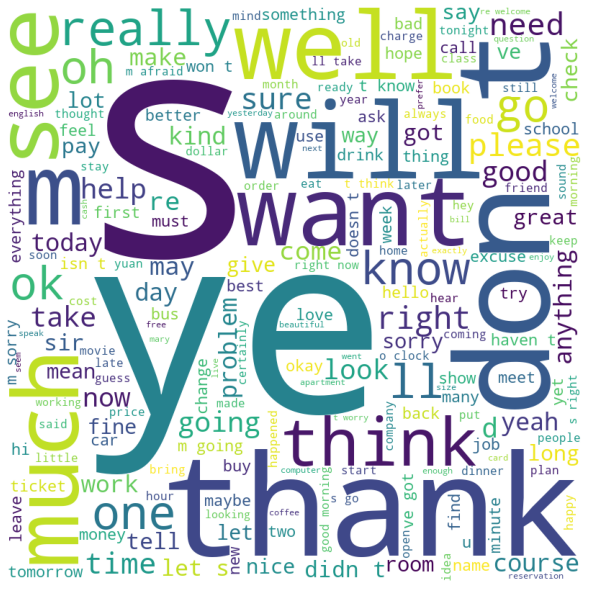

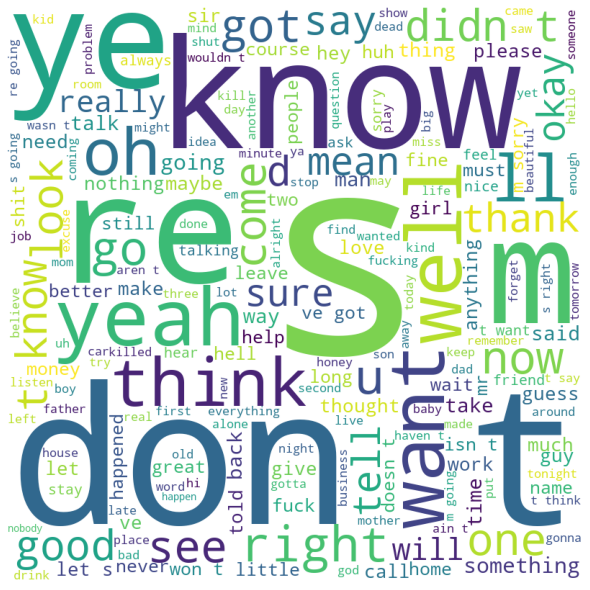

In [ ]:
# for preprocessed trian data
import matplotlib.pyplot as plt
from wordcloud import WordCloud

daily_path = os.path.join(folder_path, 'data', 'dailyDialog', 'train', 'processed_dialogues_train.txt')
movie_path = os.path.join(folder_path, 'data', 'movie-corpus', 'train', 'processed_dialogues_train.txt')
with open(daily_path, 'r') as f, open(movie_path, 'r') as f1:
  daily = f.readlines()
  movie = f1.readlines()

str_daily = ' '.join(daily)
movie_daily = ' '.join(movie)
text = [str_daily, movie_daily]
for i, t in enumerate(text):
  # Create the word cloud
  wordcloud = WordCloud(width=800, height=800, background_color='white').generate(t)

  # Display the word cloud
  plt.figure(figsize=(8, 8), facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad=0)

  # Save the image
  # plt.savefig(f"{i}.png")



In [ ]:
# For RL
def convert_response(response, batch_size):
    size1 = len(response)
    size2 = batch_size
    np_res = np.zeros((size1, size2), dtype=np.int64)
    np_lengths = np.zeros(size2, dtype=np.int64)
    for i in range(size1):
        prov = response[i].cpu().numpy()
        for j in range(prov.size):
            np_lengths[j] = np_lengths[j] + 1
            if prov.size > 1:
                np_res[i][j] = prov[j]
            else:
                np_res[i][j] = prov
    res = torch.from_numpy(np_res)
    lengths = torch.from_numpy(np_lengths)
    return res, lengths


def convert_target(target, batch_size):
    size1 = len(target)
    size2 = batch_size
    np_res = np.zeros((size1, size2), dtype=np.int64)
    mask = np.zeros((size1, size2), dtype=np.bool_)
    np_lengths = np.zeros(size2, dtype=np.int64)
    for i in range(size1):
        prov = target[i].cpu().numpy()
        for j in range(prov.size):
            np_lengths[j] = np_lengths[j] + 1
            if prov.size > 1:
                np_res[i][j] = prov[j]
            else:
                np_res[i][j] = prov

            if np_res[i][j] > 0:
                mask[i][j] = True
            else:
                mask[i][j] = False

    res = torch.from_numpy(np_res)
    lengths = torch.from_numpy(np_lengths)
    mask = torch.from_numpy(mask)
    max_target_len = torch.max(lengths)  # .detach().numpy()
    return res, mask, max_target_len


def transform_tensor_to_same_shape_as(tensor, shape):
    size1, size2 = shape
    np_new_t = np.zeros((size1, size2), dtype=np.int64)
    np_new_mask = np.zeros((size1, size2), dtype=np.bool_)
    tensor_size1, tensor_size2 = tensor.size()
    for i in range(tensor_size1):
        for j in range(tensor_size2):
            np_new_t[i][j] = tensor[i][j]
            np_new_mask[i][j] = True
    return torch.from_numpy(np_new_t), torch.from_numpy(np_new_mask)

In [ ]:
# For transformer
def create_tf_dataset(questions, answers, BATCH_SIZE=64, BUFFER_SIZE=20000):
  dataset = tf.data.Dataset.from_tensor_slices(
      (
          {"inputs": questions, "dec_inputs": answers[:, :-1]},
          {"outputs": answers[:, 1:]},
      )
  )
  # Add dataset to cache
  dataset = dataset.cache()
  # Shuffle dataset for better training accuracy
  dataset = dataset.shuffle(BUFFER_SIZE)
  # Get batches
  dataset = dataset.batch(BATCH_SIZE)
  # Prefectch to accelerate the training prorcess
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

## Models

### Seq2seq

In [ ]:
# LSTM Encoder
class Encoder(nn.Module):
    def __init__(self, hidden_size, embedding, n_layer, dropout):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.n_layer = n_layer
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layer,
                            dropout=(0 if n_layer == 1 else dropout))

    def forward(self, input_seq, input_lengths):
        # Convert input_seq to embedding
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequence
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through LSTM
        outputs, (hidden, cell) = self.lstm(packed)
        # Unpack the outputs
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Return the final hidden state
        return hidden, cell


# LSTM Decoder without attention
class Decoder(nn.Module):
    def __init__(self, embedding, n_layers, hidden_size, dropout, output_size):
        super(Decoder, self).__init__()
        self.embedding = embedding
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout = dropout

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, last_hidden, last_cell):
        # Create embedding
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded) # keep conformity with luoDecoder below
        # Forward pass LSTM
        outputs, (hidden, cell) = self.lstm(embedded, (last_hidden, last_cell))
        # Squeeze the 0 dimension
        outputs = outputs.squeeze(0)
        # Linear to output size
        outputs = self.out(outputs)
        # Cal. probability of each token
        outputs = F.softmax(outputs, dim=1)
        # Return output and hidden state
        return outputs, hidden, cell

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):  # max_length * batch_size ; batch_size
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)  # max_length * batch_size * hidden_size

        # Pack padded batch of sequences for RNN module
        # PackedSequence: 4
        # packed[0]: data, total_lengths * hidden_size; packed[1]: length tensor, lengths
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)

        # Forward pass through GRU
        # outputs: same as packed, except packed[0]: data, total_lengths * (hidden_size * #direction);
        # hidden: start from None ## (#directions * #layers) * batch_size * hidden_size
        outputs, hidden = self.gru(packed, hidden)

        # Unpack padding
        # outputs: max_length * batch_size * (hidden_size * 2) | reason for double: bidirectional
        # _: length tensor
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)

        # Sum bidirectional GRU outputs
        # :500 + 500: in the case; same as the embedding, like a point-wise operation
        outputs = outputs[:, :, :self.hidden_size] + \
                  outputs[:, :, self.hidden_size:]

        # Return output and final hidden state
        return outputs, hidden


# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(
                self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        # hidden: 1 * batch_size * hidden_size
        # - encoder_output: max_length * batch_size * hidden_size
        # - do element-wise multiplication and sum them along the hidden_size axis
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat(
            (hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        # - max_length * batch_size  --> batch_size * max_length
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)


class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model  # 'dot', 'general', 'concat'
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout  # after embedding

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time

        # Get embedding of current input word
        # - embedded: 1(token length) * batch_size * hidden_size <-- input_step: 1 * hidden_size
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)  # drop some neuron value according to the ratio

        # Forward through unidirectional GRU
        # - rnn_output: 1(token_length) * batch_size * hidden_size
        # - last_hidden: 2(n_layers) * batch_size * hidden_size
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention weights from the current GRU output
        # - attn_weights: batch_size * 1 * max_length; encoder_outputs: max_length * batch_size * hidden_size
        attn_weights = self.attn(rnn_output, encoder_outputs)

        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        # - context: batch_size * 1 * hidden_size
        # - attn_weights: batch_size * 1 * max_length; trans_encoder_outputs: batch_size * max_length * hidden_size
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))

        # Concatenate weighted context vector and GRU output using Luong eq. 5
        # - rnn_output: 1 * batch_size * hidden_size --> batch_size * hidden_size
        rnn_output = rnn_output.squeeze(0)
        # - context: batch_size * 1 * hidden_size --> batch_size * hidden_size
        context = context.squeeze(1)
        # - concat_input: batch_size * (hidden_size * 2)
        concat_input = torch.cat((rnn_output, context), 1)
        # - concat_output: batch_size * hidden_size | self.concat
        concat_output = torch.tanh(self.concat(concat_input))

        # Predict next word using Luong eq. 6
        # - output: batch_size * output_size
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)  # get the probability format

        # Return output and final hidden state
        return output, hidden


class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder, is_basic=True):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.is_basic = is_basic

    def forward(self, input_seq, input_length, max_length, is_basic):
        # Device choice
        USE_CUDA = torch.cuda.is_available()
        device = torch.device("cuda" if USE_CUDA else "cpu")

        # Forward input through encoder model
        if self.is_basic:
            encoder_hidden, encoder_cell = self.encoder(input_seq, input_length)
        else:
            encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)

        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        if self.is_basic:
            decoder_hidden, decoder_cell = encoder_hidden[:self.decoder.n_layers], \
                                            encoder_cell[:self.decoder.n_layers]
        else:
            decoder_hidden = encoder_hidden[:self.decoder.n_layers]

        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(
            1, 1, device=device, dtype=torch.long) * SOS_token

        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)

        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            if is_basic:
                decoder_output, decoder_hidden, decoder_cell = self.decoder(
                    decoder_input, decoder_hidden, decoder_cell)
            else:
                decoder_output, decoder_hidden = self.decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)

        # Return collections of word tokens and scores
        return all_tokens, all_scores

### Transformer

In [ ]:
def create_tf_dataset(questions, answers, BATCH_SIZE=64, BUFFER_SIZE=20000):
  dataset = tf.data.Dataset.from_tensor_slices(
      (
          {"inputs": questions, "dec_inputs": answers[:, :-1]},
          {"outputs": answers[:, 1:]},
      )
  )
  # Add dataset to cache
  dataset = dataset.cache()
  # Shuffle dataset for better training accuracy
  dataset = dataset.shuffle(BUFFER_SIZE)
  # Get batches
  dataset = dataset.batch(BATCH_SIZE)
  # Prefectch to accelerate the training prorcess
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset


def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights."""
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += mask * -1e9

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output


class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]



class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        assert d_model % num_heads == 0
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttentionLayer, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)
        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
        )(inputs)

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs


def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]


def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)


def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttentionLayer(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )


def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )


def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(tf.cast(step, dtype=tf.float32))  #
        arg2 = tf.cast(step, dtype=tf.float32) * (tf.cast(self.warmup_steps, dtype=tf.float32) ** -1.5)  #

        return tf.math.multiply(
            tf.math.rsqrt(tf.cast(self.d_model, dtype=tf.float32)), tf.math.minimum(arg1, arg2)
        )

def loss_function(y_true, y_pred, MAX_LENGTH=14):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH + 1))  # MAX_LENGTH - 1

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)


def accuracy(y_true, y_pred, MAX_LENGTH=14):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH + 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


def create_model(VOCAB_SIZE, optimizer, D_MODEL, NUM_HEADS, UNITS,\
                DROPOUT, NUM_LAYERS):
  # clear backend
  tf.keras.backend.clear_session()
  
  # Customize learing rate function
  learning_rate = CustomSchedule(D_MODEL)
  
  # Determine which optimizer in this experiment
  if optimizer == 'Adam':
    optimizer = tf.keras.optimizers.Adam(
        learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
  else:
    optimizer = tf.keras.optimizers.experimental.SGD(learning_rate)

  # Create the model
  model = transformer(
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT,
  )
  # Compile the model
  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

  return model



def load_model(save_path):
  ''' Load transformer model under the best parameters '''
  filename = os.path.join(save_path, 'model.h5')
  model = tf.keras.models.load_model(
      filename,
      custom_objects={
          "PositionalEncoding": PositionalEncoding,
          "MultiHeadAttentionLayer": MultiHeadAttentionLayer,
      },
      compile=False,
  )
  d_model = 256
  learning_rate = CustomSchedule(d_model)
  optimizer = tf.keras.optimizers.Adam(
      learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
  return model

### RL

In [ ]:
def rl(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, batch_size,
       teacher_forcing_ratio):
    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    # print_losses = []
    response = []

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, n_total = mask_nll_loss(
                decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            # print_losses.append(mask_loss.item() * nTotal)
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor(
                [[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, n_total = mask_nll_loss(
                decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            # print_losses.append(mask_loss.item() * nTotal)

            # ni or decoder_output
            response.append(topi)

    return loss, max_target_len, response


def ease_of_answering(input_variable, lengths, dull_responses, mask, max_target_len, encoder, decoder, batch_size,
                      teacher_forcing_ratio, voc):
    NS = len(dull_responses)
    r1 = 0
    for d in dull_responses:
        d, mask, max_target_len = output_var(d, voc)
        newD, newMask = transform_tensor_to_same_shape_as(d, input_variable.size())
        # tar, mask, max_target_len = convertTarget(d)
        forward_loss, forward_len, _ = rl(input_variable, lengths, newD, newMask, max_target_len, encoder, decoder,
                                          batch_size, teacher_forcing_ratio)
        # log (1/P(a|s)) = CE  --> log(P(a | s)) = - CE
        if forward_len > 0:
            r1 -= forward_loss / forward_len
    if len(dull_responses) > 0:
        r1 = r1 / NS
    return r1


def information_flow(responses):
    r2 = 0
    if (len(responses) > 2):
        # 2 representations obtained from the encoder for two consecutive turns pi and pi+1
        h_pi = responses[-3]
        h_pi1 = responses[-1]
        # length of the two vector might not match
        min_length = min(len(h_pi), len(h_pi + 1))
        h_pi = h_pi[:min_length]
        h_pi1 = h_pi1[:min_length]
        # cosine similarity
        # cos_sim = 1 - distance.cosine(h_pi, h_pi1)
        cos_sim = 1 - distance.cdist(h_pi.cpu().numpy(), h_pi1.cpu().numpy(), 'cosine')
        # Handle negative cos_sim
        if np.any(cos_sim <= 0):
            r2 = - cos_sim
        else:
            r2 = - np.log(cos_sim)
        r2 = np.mean(r2)
    return r2


def semantic_coherence(input_variable, lengths, target_variable, mask, max_target_len, forward_encoder, forward_decoder,
                       backward_encoder, backward_decoder, batch_size, teacher_forcing_ratio):
    # print("IN R3:")
    # print("Input_variable :", input_variable.shape)
    # print("Lengths :", lengths.shape)
    # print("Target_variable :", target_variable.shape)
    # print("Mask :", mask.shape)
    # print("Max_Target_Len :", max_target_len)
    r3 = 0
    forward_loss, forward_len, _ = rl(input_variable, lengths, target_variable, mask, max_target_len, forward_encoder,
                                      forward_decoder, batch_size, teacher_forcing_ratio)
    ep_input, lengths_trans = convert_response(target_variable, batch_size)
    # print("ep_input :", ep_input.shape)
    # print("Lengths transformed :", lengths_trans.shape)
    ep_target, mask_trans, max_target_len_trans = convert_target(target_variable, batch_size)  # target_variable
    # print("ep_target :", ep_target.shape)
    # print("mask transformed :", mask_trans.shape)
    # print("max_target_len_trans :", max_target_len_trans)
    backward_loss, backward_len, _ = rl(ep_input, lengths_trans, ep_target, mask_trans, max_target_len_trans,
                                        backward_encoder, backward_decoder, batch_size, teacher_forcing_ratio)
    if forward_len > 0:
        r3 += forward_loss / forward_len
    if backward_len > 0:
        r3 += backward_loss / backward_len
    return r3


l1 = 0.25
l2 = 0.25
l3 = 0.5

dull_responses = ["i do not know what you are talking about.", "i do not know.", "you do not know.",
                  "you know what i mean.", "i know what you mean.", "you know what i am saying.",
                  "you do not know anything."]

MIN_COUNT = 3
MAX_LENGTH = 15


def calculate_rewards(input_var, lengths, target_var, mask, max_target_len, forward_encoder, forward_decoder,
                      backward_encoder, backward_decoder, batch_size, teacher_forcing_ratio, voc):
    # rewards per episode
    ep_rewards = []
    # indices of current episode
    ep_num = 1
    # list of responses
    responses = []
    # input of current episode
    ep_input = input_var
    # target of current episode
    ep_target = target_var

    # ep_num bounded -> to redefine (MEDIUM POST REWARD)
    while (ep_num <= 10):

        print(ep_num)
        # generate current response with the forward model
        _, _, curr_response = rl(ep_input, lengths, ep_target, mask, max_target_len, forward_encoder, forward_decoder,
                                 batch_size, teacher_forcing_ratio)

        # Break if :
        # 1 -> dull response
        # 2 -> response is less than MIN_LENGTH
        # 3 -> repetition ie curr_response in responses
        if len(curr_response) < MIN_COUNT or (curr_response in dull_responses) or (curr_response in responses):
            break

        # Ease of answering
        r1 = ease_of_answering(ep_input, lengths, dull_responses, mask, max_target_len, forward_encoder,
                               forward_decoder, batch_size, teacher_forcing_ratio, voc)

        # Information flow
        r2 = information_flow(responses)

        # Semantic coherence
        r3 = semantic_coherence(ep_input, lengths, target_var, mask, max_target_len, forward_encoder, forward_decoder,
                                backward_encoder, backward_decoder, batch_size, teacher_forcing_ratio)

        # Final reward as a weighted sum of rewards
        r = l1 * r1 + l2 * r2 + l3 * r3

        # Add the current reward to the list
        ep_rewards.append(r.detach().cpu().numpy())

        # We can add the response to responses list
        curr_response, lengths = convert_response(curr_response, batch_size)
        curr_response = curr_response.to(device)
        responses.append(curr_response)

        # Next input is the current response
        ep_input = curr_response
        # Next target -> dummy
        ep_target = torch.zeros(MAX_LENGTH, batch_size, dtype=torch.int64)
        ep_target = ep_target.to(device)

        # Turn off the teacher forcing after first iteration -> dummy target
        teacher_forcing_ratio = 0
        ep_num += 1

    # Take the mean of the episodic rewards
    return np.mean(ep_rewards) if len(ep_rewards) > 0 else 0


def training_rl_loop(pairs, voc, n_iteration, batch_size, embedding, forward_encoder, forward_decoder, backward_encoder,
                     backward_decoder, forward_encoder_optimizer, forward_decoder_optimizer, backward_encoder_optimizer,
                     backward_decoder_optimizer, clip, teacher_forcing_ratio, print_every, save_every, save_dir, model_name,
                     base_model, corpus_name, encoder_n_layers, decoder_n_layers, hidden_size, checkpoint=None):

    # Load batches for each iteration
    training_batches = [get_2_batch_indexes(voc, [random.choice(pairs) for _ in range(batch_size)])
                        for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if checkpoint:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        print("Iteration", iteration)
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Zero gradients the optimizer
        forward_encoder_optimizer.zero_grad()
        forward_decoder_optimizer.zero_grad()

        backward_encoder_optimizer.zero_grad()
        backward_decoder_optimizer.zero_grad()

        # Forward
        forward_loss, forward_len, _ = rl(input_variable, lengths, target_variable, mask, max_target_len,
                                          forward_encoder, forward_decoder, batch_size, teacher_forcing_ratio)

        # Calculate reward
        reward = calculate_rewards(input_variable, lengths, target_variable, mask, max_target_len, forward_encoder,
                                   forward_decoder, backward_encoder, backward_decoder, batch_size,
                                   teacher_forcing_ratio, voc)

        # Update forward seq2seq with loss scaled by reward
        # - r = p(s1, ..., sn) * r(s1, ..., sn), aim to increase r
        # - p(s1, ..., sn) ~= - loss, then
        # increase r equals to decrease loss * r(s1, ..., sn), as like below
        loss = forward_loss * reward  # this combines the advantage of seq2seq and rl

        loss.backward()
        forward_encoder_optimizer.step()
        forward_decoder_optimizer.step()

        # Run a training iteration with batch
        print_loss += loss / forward_len

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration,
                                                                                          iteration / n_iteration * 100,
                                                                                          print_loss_avg))
            print_loss = 0

        # SAVE CHECKPOINT TO DO
        if iteration % save_every == 0:
            directory = os.path.join(save_dir, model_name,
                                     corpus_name,
                                     '{}_{}-{}_{}'.format(base_model, encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': forward_encoder.state_dict(),
                'de': forward_decoder.state_dict(),
                'en_opt': forward_encoder_optimizer.state_dict(),
                'de_opt': forward_decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))


def train_rl():

    # Device
    USE_CUDA = torch.cuda.is_available()
    cuda_name = 'cuda' if USE_CUDA else 'cpu'
    device = torch.device(cuda_name)

    # Define path, filename for index and save
    corpus_name = "dailyDialog"
    mode = "train"
    fileName = "formatted_dialogues_train.txt"
    datafile_dir = os.path.join(folder_path, "data", corpus_name, mode, fileName)
    save_dir = os.path.join(folder_path, "data", "save")

    # Load voc and processed pairs
    voc, pairs = load_prepare_data(corpus_name, datafile_dir, max_length=15, min_count=3, reverse=False)

    # Configure models
    model_name = 'cb_rl'
    base_model = 'cb_seq2seq'
    size = voc.num_words
    dropout = 0.1
    encoder_n_layers = 2
    decoder_n_layers = 2
    hidden_size = 500
    attn_model = 'dot'  # can adopt 'general', 'concat' mode as well

    # Configure training/optimization
    n_iteration = 10000  # 10000
    batch_size = 64
    teacher_forcing_ratio = 0.5
    learning_rate = 0.0001
    decoder_learning_ratio = 5.0
    clip = 50.0
    print_every = 1
    save_every = 1000

    ################### Initialize forward model based on training checkpoint ############################
    fb = 'forward'
    checkpoint_iter = 10000  # 10000
    loadFile = os.path.join(save_dir, base_model, corpus_name,
                            '{}_{}-{}_{}'.format(fb, encoder_n_layers, decoder_n_layers, hidden_size),
                            '{}_checkpoint.tar'.format(checkpoint_iter))

    # Load model
    # - If loading on same machine the model was trained on
    checkpoint = torch.load(loadFile)
    # - If loading a model trained on GPU to CPU
    # checkpoint = torch.load(loadFile, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']

    # Build forward encoder and decoder
    print('Building forward encoder and decoder ...')
    # Initialize, load word embeddings
    embedding = nn.Embedding(size, hidden_size)
    embedding.load_state_dict(embedding_sd)
    # Initialize, load encoder & decoder models
    encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
    decoder = LuongAttnDecoderRNN(
        attn_model, embedding, hidden_size, size, decoder_n_layers, dropout)
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
    # Use appropriate device
    forward_encoder = encoder.to(device)
    forward_decoder = decoder.to(device)
    print('Forward models built and ready to go!')

    # Ensure dropout layers are in train mode
    forward_encoder.train()
    forward_decoder.train()

    # Initialize forward model optimizers
    print('Building forward model optimizers ...')
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(
        decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)
    # - Rename it
    forward_encoder_optimizer = encoder_optimizer
    forward_decoder_optimizer = decoder_optimizer


    ################### Initialize backward model based on training checkpoint ############################
    fb = 'backward'
    loadFile = os.path.join(save_dir, base_model, corpus_name,
                            '{}_{}-{}_{}'.format(fb, encoder_n_layers, decoder_n_layers, hidden_size),
                            '{}_checkpoint.tar'.format(checkpoint_iter))

    # Load model
    # - If loading on same machine the model was trained on
    checkpoint = torch.load(loadFile)
    # - If loading a model trained on GPU to CPU
    checkpoint = torch.load(loadFile, map_location=torch.device('cuda:0'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']

    # Build backward encoder and decoder
    print('Building backward encoder and decoder ...')
    # Initialize, load word embeddings
    embedding = nn.Embedding(size, hidden_size)
    embedding.load_state_dict(embedding_sd)
    # Initialize, load encoder & decoder models
    encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
    decoder = LuongAttnDecoderRNN(
        attn_model, embedding, hidden_size, size, decoder_n_layers, dropout)
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
    # Use appropriate device
    backward_encoder = encoder.to(device)
    backward_decoder = decoder.to(device)
    print('Backward models built and ready to go!')

    # Ensure dropout layers are in train mode
    backward_encoder.train()
    backward_decoder.train()

    # Initialize forward model optimizers
    print('Building forward model optimizers ...')
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(
        decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)
    # - Rename it
    backward_encoder_optimizer = encoder_optimizer
    backward_decoder_optimizer = decoder_optimizer

    # If you have cuda, configure cuda to call
    if cuda_name == 'cuda':
        for state in forward_encoder_optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

        for state in forward_decoder_optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

        for state in backward_encoder_optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

        for state in backward_decoder_optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

    # Run training iterations
    print("Starting Training!")
    checkpoint = None  # for first training
    training_rl_loop(pairs, voc, n_iteration, batch_size, embedding, forward_encoder, forward_decoder, backward_encoder,
                     backward_decoder, forward_encoder_optimizer, forward_decoder_optimizer, backward_encoder_optimizer,
                     backward_decoder_optimizer, clip, teacher_forcing_ratio, print_every, save_every, save_dir, model_name,
                     base_model, corpus_name, forward_encoder.n_layers, forward_decoder.n_layers, hidden_size, checkpoint)
    
# train_rl()

## Loss


In [ ]:
def mask_nll_loss(inp, target, mask):

    # Device choice
    USE_CUDA = torch.cuda.is_available()
    device = torch.device("cuda" if USE_CUDA else "cpu")

    # Total number of true token in the batch
    n_total = mask.sum()  # tensor(64)

    # Cal. cross entropy
    # - inp: batch_size * output_size
    # - target.view(-1, 1): batch_size * 1;
    # - cross_entropy: batch_size
    cross_entropy = - \
        torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))

    # Sum up the real cross entropy and get the mean
    loss = cross_entropy.masked_select(mask).mean()

    # Add loss to device
    loss = loss.to(device)

    return loss, n_total.item()

## Train

### Seq2Seq - Basic

In [ ]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, encoder_optimizer, decoder_optimizer, batch_size, clip, teacher_forcing_ratio):

    # Device choice
    USE_CUDA = torch.cuda.is_available()
    device = torch.device("cuda" if USE_CUDA else "cpu")

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu  ##
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_hidden, encoder_cell = encoder(input_variable, lengths)  # input_hidden, an attribute of the encoder

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    # -decoder_hidden: n_layers * batch_size * hidden_size
    decoder_hidden = encoder_hidden[:decoder.n_layers]
    decoder_cell = encoder_cell[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False  # in this ratio, must use

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            # - decoder_output: batch_size * output_size (num_word|size)
            decoder_output, decoder_hidden, decoder_cell = decoder(
                decoder_input, decoder_hidden, decoder_cell
            )

            # Teacher forcing: next input is current target
            # - decoder_input: 1 (token) * batch_size
            decoder_input = target_variable[t].view(1, -1)

            # Calculate and accumulate loss
            # - decoder_output: batch_size * output_size
            # - target_variable[t]: 1 * batch_size
            # - mask[t]: 1 * batch_size
            mask_loss, n_total = mask_nll_loss(
                decoder_output, target_variable[t], mask[t])

            # Loss
            # - all mean loss for back propagation
            loss += mask_loss
            # - total print losses
            print_losses.append(mask_loss.item() * n_total)
            # - all total numbers
            n_totals += n_total
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor(
                [[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, n_total = mask_nll_loss(
                decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * n_total)
            n_totals += n_total

    # Perform backpropagation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals  # avg loss for the batch


def train_iters(pairs, fb, voc, n_iteration, batch_size, embedding, encoder, decoder, encoder_optimizer,
                decoder_optimizer, clip, teacher_forcing_ratio, print_every, save_every, save_dir, model_name, corpus_name,
                encoder_n_layers, decoder_n_layers, hidden_size, checkpoint):
    """ Train iterations for batches, print losses, and save checkpoint file for further training or plot"""

    # Load batches for each iteration
    training_batches = [get_2_batch_indexes(voc, [random.choice(pairs) for _ in range(batch_size)])
                        for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if checkpoint:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch  ## why this 5 items

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, batch_size, clip, teacher_forcing_ratio)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:  # every print_every times
            print_loss_avg = print_loss / print_every  # cal. the average loss for the loss for the latest #print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(
                iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0  # reset loss sum

        # Save checkpoint
        # if iteration % save_every == 0:  # every save_every times
        #     directory = os.path.join(save_dir, model_name, corpus_name, '{}_{}-{}_{}'.format(
        #         fb, encoder_n_layers, decoder_n_layers, hidden_size))  # get save directory path
        #     if not os.path.exists(directory):  # if no such directory
        #         os.makedirs(directory) # make one
        #     torch.save({  # save items
        #         'iteration': iteration,  # for further training purpose
        #         'en': encoder.state_dict(),  # encoder
        #         'de': decoder.state_dict(),  # decoder
        #         'en_opt': encoder_optimizer.state_dict(),  # encoder_optimizer
        #         'de_opt': decoder_optimizer.state_dict(),  # decoder_optimizer
        #         'loss': loss,  # loss further training or plot
        #         'voc_dict': voc.__dict__,  # voc
        #         'embedding': embedding.state_dict()  # embedding
        #     }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))  # at the end, n_iteration


def train_basic_seq2seq(cn):
    '''
      The reason for writing in below format is that we can continue training if interrupted 
    '''
    # Device
    USE_CUDA = torch.cuda.is_available()
    cuda_name = 'cuda' if USE_CUDA else 'cpu'
    device = torch.device(cuda_name)


    # Define path, filename for index and save
    corpus_name = cn  # dailyDialog
    mode = "train"
    fileName = "formatted_dialogues_train.txt"
    datafile_dir = os.path.join(folder_path, "data", corpus_name, mode, fileName)
    save_dir = os.path.join(folder_path, "data", "save")


    # Load voc and processed pairs
    # - if initialize forward model, set reverse as False; for backward model, then reverse is True
    # - above for reinforcement learning
    fb = 'forward'
    reverse_bool=False
    voc, pairs = load_prepare_data(corpus_name, datafile_dir, max_length=15, min_count=3, reverse=reverse_bool)

    print('for testing!!')
    for pair in pairs[:10]:
        print(pair)

    # Configure models
    model_name = 'cb_basic_seq2seq'
    size = voc.num_words
    dropout = 0
    encoder_n_layers = 1
    decoder_n_layers = 1
    hidden_size = 500

    # Configure training/optimization
    n_iteration = 10000 
    batch_size = 64
    teacher_forcing_ratio = 1
    learning_rate = 0.0001
    decoder_learning_ratio = 5.0
    clip = 50.0
    print_every = 1
    save_every = 1000

    # Check if there is checkpoint file,
    # if so, we load first; otherwise we prepare embeddings, encoder, decoder models, and their optimizer
    checkpoint_iter = 0  # 1000
    loadFile = os.path.join(save_dir, model_name, corpus_name,
                            '{}_{}-{}_{}'.format(fb, encoder_n_layers, decoder_n_layers, hidden_size),
                            '{}_checkpoint.tar'.format(checkpoint_iter))
    print(loadFile)
    loadFile = loadFile if os.path.exists(loadFile) else None

    # Load model if a loadFile is provided
    if loadFile:
        # Load checkpoint across devices (ref to official documentation if you are not familiar with this topic)

        # If loading on same machine the model was trained on (my current case in colab- cpu2gpu)
        checkpoint = torch.load(loadFile)
        # # If loading a model trained on CPU to GPU
        checkpoint = torch.load(loadFile, map_location=torch.device('cuda:0'))

        encoder_sd = checkpoint['en']   # all items can be found in part: save checkpoint, of trainIter function
        decoder_sd = checkpoint['de']
        encoder_optimizer_sd = checkpoint['en_opt']
        decoder_optimizer_sd = checkpoint['de_opt']
        embedding_sd = checkpoint['embedding']
        voc.__dict__ = checkpoint['voc_dict']
    else:
        checkpoint = None

    # Build encoder and decoder
    print('Building encoder and decoder ...')
    # Initialize word embeddings
    embedding = nn.Embedding(size, hidden_size)
    if loadFile:
        embedding.load_state_dict(embedding_sd)
    # Initialize encoder & decoder models
    encoder = Encoder(hidden_size, embedding, encoder_n_layers, dropout)
    decoder =  Decoder(
        embedding, decoder_n_layers, hidden_size, dropout, size)
    if loadFile:
        encoder.load_state_dict(encoder_sd)
        decoder.load_state_dict(decoder_sd)
    # Use appropriate device
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    print('Models built and ready to go!')
    # Ensure dropout layers are in train mode
    # compared to .eval(), .train() will auto-cal gradient and dropout for robustness
    encoder.train()
    decoder.train()

    # Initialize optimizers
    print('Building optimizers ...')
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(
        decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
    if loadFile:
        encoder_optimizer.load_state_dict(encoder_optimizer_sd)
        decoder_optimizer.load_state_dict(decoder_optimizer_sd)

    # If you have cuda, configure cuda to call for optimizer
    if cuda_name == 'cuda':
        for state in encoder_optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

        for state in decoder_optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

    # Run training iterations
    print("Starting Training!")
    train_iters(pairs, fb, voc, n_iteration, batch_size, embedding, encoder, decoder, encoder_optimizer,
                decoder_optimizer, clip, teacher_forcing_ratio, print_every, save_every, save_dir, model_name,
                corpus_name, encoder_n_layers, decoder_n_layers, hidden_size, checkpoint)
    
# train_basic_seq2seq(corpus_name)  # The step has been done in my loacal machine with a cpu

### Seq2seq - Advance

In [ ]:
def train_ad(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, encoder_optimizer, decoder_optimizer, batch_size, clip, teacher_forcing_ratio):

    # Device choice
    USE_CUDA = torch.cuda.is_available()
    device = torch.device("cuda" if USE_CUDA else "cpu")

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu  ##
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)  # input_hidden, an attribute of the encoder

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    # -decoder_hidden: n_layers * batch_size * hidden_size
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False  # in this ratio, must use

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            # - decoder_output: batch_size * output_size (num_word|size)
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            # Teacher forcing: next input is current target
            # - decoder_input: 1 (token) * batch_size
            decoder_input = target_variable[t].view(1, -1)

            # Calculate and accumulate loss
            # - decoder_output: batch_size * output_size
            # - target_variable[t]: 1 * batch_size
            # - mask[t]: 1 * batch_size
            mask_loss, n_total = mask_nll_loss(
                decoder_output, target_variable[t], mask[t])

            # Loss
            # - all mean loss for back propagation
            loss += mask_loss
            # - total print losses
            print_losses.append(mask_loss.item() * n_total)
            # - all total numbers
            n_totals += n_total
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor(
                [[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, n_total = mask_nll_loss(
                decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * n_total)
            n_totals += n_total

    # Perform backpropagation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals  # avg loss for the batch


def train_iters_ad(pairs, fb, voc, n_iteration, batch_size, embedding, encoder, decoder, encoder_optimizer,
                decoder_optimizer, clip, teacher_forcing_ratio, print_every, save_every, save_dir, model_name, corpus_name,
                encoder_n_layers, decoder_n_layers, hidden_size, checkpoint):
    """ Train iterations for batches, print losses, and save checkpoint file for further training or plot"""

    # Load batches for each iteration
    training_batches = [get_2_batch_indexes(voc, [random.choice(pairs) for _ in range(batch_size)])
                        for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if checkpoint:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch  ## why this 5 items

        # Run a training iteration with batch
        loss = train_ad(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, batch_size, clip, teacher_forcing_ratio)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:  # every print_every times
            print_loss_avg = print_loss / print_every  # cal. the average loss for the loss for the latest #print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(
                iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0  # reset loss sum

        # Save checkpoint
        # if iteration % save_every == 0:  # every save_every times
        #     directory = os.path.join(save_dir, model_name, corpus_name, '{}_{}-{}_{}'.format(
        #         fb, encoder_n_layers, decoder_n_layers, hidden_size))  # get save directory path
        #     if not os.path.exists(directory):  # if no such directory
        #         os.makedirs(directory) # make one
        #     torch.save({  # save items
        #         'iteration': iteration,  # for further training purpose
        #         'en': encoder.state_dict(),  # encoder
        #         'de': decoder.state_dict(),  # decoder
        #         'en_opt': encoder_optimizer.state_dict(),  # encoder_optimizer
        #         'de_opt': decoder_optimizer.state_dict(),  # decoder_optimizer
        #         'loss': loss,  # loss further training or plot
        #         'voc_dict': voc.__dict__,  # voc
        #         'embedding': embedding.state_dict()  # embedding
        #     }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))  # at the end, n_iteration


def train_advance_seq2seq(cn):

    # Device
    USE_CUDA = torch.cuda.is_available()
    cuda_name = 'cuda' if USE_CUDA else 'cpu'
    device = torch.device(cuda_name)

    # Define path, filename for index and save
    corpus_name = cn
    mode = "train"
    fileName = "formatted_dialogues_train.txt"
    datafile_dir = os.path.join(folder_path, "data", corpus_name, mode, fileName)
    save_dir = os.path.join(folder_path, "data", "save")

    # reverse_ls = [False, True]
    # fb_ls = ['forward', 'backward']
    #
    # # For reinforcement learning preparation
    # # - train forward and backward seq2seq models
    # for reverse, fb in list(zip(reverse_ls, fb_ls)):

    fb = 'forward'
    reverse_bool=False

    # Load voc and processed pairs
    # - if initialize forward model, set reverse as False; for backward model, then reverse is True
    # - above for reinforcement learning

    voc, pairs = load_prepare_data(corpus_name, datafile_dir, max_length=15, min_count=3, reverse=reverse_bool)

    # Configure models
    model_name = 'cb_seq2seq'
    size = voc.num_words
    dropout = 0.1
    encoder_n_layers = 2
    decoder_n_layers = 2
    hidden_size = 500
    attn_model = 'dot'  # can adopt 'general', 'concat' mode as well

    # Configure training/optimization
    n_iteration = 10000 # 10000
    batch_size = 64
    teacher_forcing_ratio = 1
    learning_rate = 0.0001
    decoder_learning_ratio = 5.0
    clip = 50.0
    print_every = 1
    save_every = 1000

    # Check if there is checkpoint file,
    # if so, we load first; otherwise we prepare embeddings, encoder, decoder models, and their optimizer
    checkpoint_iter = 0  # 1000
    loadFile = os.path.join(save_dir, model_name, corpus_name,
                            '{}_{}-{}_{}'.format(fb, encoder_n_layers, decoder_n_layers, hidden_size),
                            '{}_checkpoint.tar'.format(checkpoint_iter))
    print(loadFile)
    loadFile = loadFile if os.path.exists(loadFile) else None

    # Load model if a loadFile is provided
    if loadFile:
        # Load checkpoint across devices (ref to official documentation if you are not familiar with this topic)

        # If loading on same machine the model was trained on (my current case - cpu2cpu)
        checkpoint = torch.load(loadFile)
        # # If loading a model trained on GPU to CPU
        # checkpoint = torch.load(loadFile, map_location=torch.device('cpu'))

        encoder_sd = checkpoint['en']   # all items can be found in part: save checkpoint, of trainIter function
        decoder_sd = checkpoint['de']
        encoder_optimizer_sd = checkpoint['en_opt']
        decoder_optimizer_sd = checkpoint['de_opt']
        embedding_sd = checkpoint['embedding']
        voc.__dict__ = checkpoint['voc_dict']
    else:
        checkpoint = None

    # Build encoder and decoder
    print('Building encoder and decoder ...')
    # Initialize word embeddings
    embedding = nn.Embedding(size, hidden_size)
    if loadFile:
        embedding.load_state_dict(embedding_sd)
    # Initialize encoder & decoder models
    encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
    decoder = LuongAttnDecoderRNN(
        attn_model, embedding, hidden_size, size, decoder_n_layers, dropout)
    if loadFile:
        encoder.load_state_dict(encoder_sd)
        decoder.load_state_dict(decoder_sd)
    # Use appropriate device
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    print('Models built and ready to go!')
    # Ensure dropout layers are in train mode
    # compared to .eval(), .train() will auto-cal gradient and dropout for robustness
    encoder.train()
    decoder.train()

    # Initialize optimizers
    print('Building optimizers ...')
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(
        decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
    if loadFile:
        encoder_optimizer.load_state_dict(encoder_optimizer_sd)
        decoder_optimizer.load_state_dict(decoder_optimizer_sd)

    # If you have cuda, configure cuda to call for optimizer
    if cuda_name == 'cuda':
        for state in encoder_optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

        for state in decoder_optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

    # Run training iterations
    print("Starting Training!")
    train_iters_ad(pairs, fb, voc, n_iteration, batch_size, embedding, encoder, decoder, encoder_optimizer,
                decoder_optimizer, clip, teacher_forcing_ratio, print_every, save_every, save_dir, model_name,
                corpus_name, encoder_n_layers, decoder_n_layers, hidden_size, checkpoint)

# train_advance_seq2seq()

### transformer

In [ ]:
def train_transformer(cn):
  # Define path, filename for index and save
  corpus_name = cn  #  dailyDialog
  mode = "train"
  fileName = "formatted_dialogues_train.txt"
  datafile_dir = os.path.join(folder_path, "data", corpus_name, mode, fileName)
  save_dir = os.path.join(folder_path, "data", "save", 'cb_transformer')
  
  # Best parameters
  optimizer, epoch, batch_size, d_model, heads, units, dropout, n_layers = \
      'Adam', 20, 64, 256, 4, 300, 0.1, 1
  print(f'\nParameters in the Evaluation Experiment')
  print(f'Optimizer:{optimizer}\nEpoch:{epoch}\nBatch_size:{batch_size}\n\
D_model:{d_model}\nHeads:{heads}\nUnits:{units}\nDroupout:{dropout}\n\
N_layers:{n_layers}\n')
  
  # Load voc and processed pairs
  fb = 'forward'
  reverse_bool=False
  voc, pairs = load_prepare_data(corpus_name, datafile_dir, max_length=15, min_count=3, reverse=reverse_bool)
  print(f'voc:{voc.num_words}, pairs:{len(pairs)}, {pairs[0]}')
  # Sort the string batches according to the length of question in descending order
  pairs.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
  # Get input and output strings from pairs
  input, output = [], []
  for pair in pairs:
    input.append(pair[0])
    output.append(pair[1])
  print(input, '\n', f'length: {len(input)}')
  # Get the index for qa pairs
  trans_style = True
  input_index = [indexes_from_sentence(voc, sentence, trans_style) for sentence in input]
  output_index = [indexes_from_sentence(voc, sentence, trans_style) for sentence in output]
  print(f'input_index 0:{input_index[0]}')
  # Padding to the max_length of q or a strings
  MAX_LENGTH = 14
  pad_inputs, pad_outputs = [], []
  pad_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        input_index, maxlen=MAX_LENGTH+2, padding="post"
    )  
  pad_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      output_index, maxlen=MAX_LENGTH+2, padding="post"
  )  
  print(len(pad_inputs))
  # Create the train dataset
  train_dataset = create_tf_dataset(pad_inputs, pad_outputs, batch_size)
  print(train_dataset)
  # Create the model and compile it
  model = create_model(voc.num_words, optimizer, d_model, heads, \
                        units, dropout, n_layers)    
  # Train the model 
  model.fit(train_dataset, epochs=epoch)
  # Save the model
  # file_name = f'model_{corpus_name}.h5'
  # file_path = os.path.join(save_dir, file_name)
  # tf.keras.models.save_model(model, filepath=file_path, include_optimizer=False)
  return model

# model =train_transformer()

## Chat and Evaluate

In [ ]:
# for transformer
def predict_transformer(sentence, model, voc, MAX_LENGTH=15):
    # words -> indexes
    sentence = indexes_from_sentence(voc, sentence)
    sentence = tf.expand_dims([SOS_token] + sentence, axis=0)  # sentence already has EOS_token
    output = tf.expand_dims([SOS_token], 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, EOS_token):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)
    # Change the format
    output = tf.squeeze(output, axis=0)
    # Get words for the sentence
    output = output.numpy().tolist()
    decoded_words = [voc.index2word[token] for token in output]
    return decoded_words

def evaluate(encoder, decoder, searcher, voc, sentence, is_basic, max_length=15):
    """ Evaluate input sentence. """

    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexes_from_sentence(voc, sentence)]

    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])

    # Transpose dimensions of batch to match models' expectations
    # - max_length * batch_size
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)

    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to('cpu')  # $$$$$$$$$$$$$$$$$$$$$$$$$$$$$

    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length, is_basic)

    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]

    return decoded_words


def chat(encoder, decoder, searcher, model, voc, is_basic, is_transformer):
    """ Evaluate input using while loop and greedy search decoder"""

    while 1:
        try:
            # Get input sentence
            input_sentence = input('> ')

            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break

            # Normalize sentence
            input_sentence = normalize_string(input_sentence)
            # Choose the model
            if not is_transformer:
              # Evaluate sentence
              output_words = evaluate(encoder, decoder, searcher, voc, input_sentence, is_basic)
            else:
              output_words = predict_transformer(input_sentence, model, voc)
            # Format and print response sentence
            output_words[:] = [x for x in output_words \
                               if not (x == 'EOS' or x == 'PAD' or x == 'SOS')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")


def save_single_turn_human(encoder, decoder, searcher, voc, qa_dir, save_dir, \
                           model_name, corpus_name, human_file, is_basic, \
                           is_transformer, model=None, max_length=15):
    """ Evaluate the response accuracy using pre-defined questions under models """

    # Define path for directory and file name
    save_file = os.path.join(save_dir, model_name, corpus_name, human_file)
    response = ''
    # Get all questions
    with open(qa_dir, 'r') as f:
        questions = f.readlines()
    # Loop each question
    r_i = 1  # re-index for valid pairs
    for i, question in enumerate(questions):
        try:
            # Normalize the question string
            question = normalize_string(question)
            # Choose the model 
            if not is_transformer:
              # Generate the response
              output_words = evaluate(encoder, decoder, searcher, voc, question, is_basic)
            else:
              output_words = predict_transformer(question, model, voc)
            # Convert response words to string
            output_words[:] = [x for x in output_words \
                               if not (x == 'EOS' or x == 'PAD' or x == 'SOS')]
            output_sentence = ' '.join(output_words) + '\n'
            pairs = str(r_i) + ' - ' + str(i) + '. ' + question + '#########' + output_sentence
            # Add to the response string
            response += pairs
            # For re-index counter
            r_i += 1
        except KeyError:
            print('Error: Unknown word')

    # Write it into file for further human check
    with open(save_file, 'w') as f:
        f.write(response)


def evaluate_multi_turns(encoder, decoder, searcher, voc, n_turns, question_dir, is_basic):
    """ Evaluate multi-turns conversation """

    length_ls = []  # lengths of turn before dull response or repetitive sentence
    r_unigram_ls = []  # type token ratio for the uni-gram
    r_bigram_ls = []  # type token ratio for the bigram

    stop_string = ["i don t know", 'i do not know']  # strings to stop
    n_invalid = 0  # number of invalid question

    # Open question directory
    with open(question_dir, 'r') as questions:
        # Get questions list
        question_ls = questions.read().split('\n')[1:]

        # for loop each question
        for input_sentence in question_ls:
            n_iter = 0  # number of turns
            is_break = False  #
            is_key = False  # boolean for
            # Loop ten turns for the question
            while n_iter < n_turns:
                # Check if errors - unknown words
                try:
                    # Normalize the input sentence
                    input_sentence = normalize_string(input_sentence)
                    # Get the output sentence
                    output_words = evaluate(encoder, decoder, searcher, voc, input_sentence, is_basic)
                    output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]  # formate it
                    output_sentence = ' '.join(output_words)  # to string

                    # Check if output_sentence contains "I don't know" and token similarity between two turns
                    token_sim = textdistance.jaccard(input_sentence.split(), output_sentence.split())
                    if (stop_string[0] in output_sentence) or \
                            (stop_string[1] in output_sentence) or \
                            (token_sim > 0.5):
                        length_ls.append(n_iter)  # add the current number of turns
                        is_break = True
                        break  # then break the while loop, go to next question

                    # Check diversity for uni-gram using type-token ratio
                    r_unigram_ls.append(len(set(output_words)) / len(output_words))

                    # Check diversity for bigrams
                    bigram = list(ngrams(output_words, 2))
                    r_bigram_ls.append(len(set(bigram)) / len(bigram))

                    # Regard current output as next input
                    input_sentence = output_sentence
                    # Add 1 to number of turns
                    n_iter += 1
                # if errors, print unknown word
                except KeyError:
                    n_invalid += 1  # add one more to number of invalid question
                    print('Error: Encountered unknown word.')
                    is_key = True
                    break  # break for next question
            # If without dull response but also under valid question
            if (not is_break) and (not is_key): length_ls.append(9)  # achieved by boolean value check
            # break
        n_valid = len(question_ls) - n_invalid  # number of valid question
        n_length = sum(length_ls) / n_valid  # avg length of valid turns passed before seeing dull resp or rep.
        avg_r_unigram = sum(r_unigram_ls) / len(r_unigram_ls)  # avg type token ratio for uni-gram of all responses
        avg_r_bigram = sum(r_bigram_ls) / len(r_bigram_ls)  # avg type token ratio for big-ram of all responses
    return n_length, avg_r_unigram, avg_r_bigram


def evaluate_single_turn_human(save_dir, model_name, corpus_name, human_file):
    """ Evaluate single turn response quality by cal. the average points in modified file measured by human"""
    # Get the data file path
    data_file = os.path.join(save_dir, model_name, corpus_name, human_file)
    # Initialize the total points as 0
    total_ps = 0
    # Open the data file
    with open(data_file, 'r') as f:
        lines = f.readlines()
    # Loop each line to get the point for that qa pair
    for line in lines:
        line_ls = line.strip().split(' |')
        point = float(line_ls[0])
        # sum the points up
        total_ps += point
    # Get the average points and print
    avg_point = total_ps / len(lines)
    print(f'Avg point for {model_name}: {avg_point}')


def evaluate_single_turn_bleu(encoder, decoder, searcher, voc, qa_dir, save_dir, model_name, \
                           corpus_name, is_basic, is_bleu, model=None, max_length=15):
    """ Evaluate the response accuracy using questions in test data under models using bleu """

    # Define path for directory and file name
    # save_file = os.path.join(save_dir, model_name, corpus_name, bleu_file)
    # Get all qa pairs in test data
    with open(qa_dir, 'r') as f:
        qas = f.readlines()
    
    # Loop each question and answer
    r_i = 1  # re-index for valid pairs
    chencherry = nltk.translate.bleu_score.SmoothingFunction()
    nlp = spacy.load("en_core_web_lg")
    total_score = 0
    for qa in qas:
        try:
            # Get the quesiton and answer
            qa = qa.strip().split('\t')
            question, answer = qa[0], qa[1]
            # Normalize the question string
            question = normalize_string(question)
            # Choose the model
            if model_name != 'transformer':
              # Generate the response
              output_words = evaluate(encoder, decoder, searcher, voc, question, is_basic)
            else:
              # Get the word list of predicted response
              output_words = predict_transformer(question, model, voc)
            # Convert response words to string
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD' or x == 'SOS')]
            # Get score between the predicted sentence and reference one
            if is_bleu == 'bleu':
              answer = nltk.word_tokenize(answer)
              temp_score = nltk.translate.bleu_score.sentence_bleu([output_words], answer, \
                                                                  smoothing_function=chencherry.method1)
            else:  # for 'similartiy'
              output = ' '.join(output_words)
              doc1, doc2 = nlp(output), nlp(answer)
              temp_score = doc1.similarity(doc2)
      
            # Add to the total score
            total_score += temp_score
            # For re-index counter
            r_i += 1
        except KeyError:
            continue

    # Cal. the average score
    if r_i != 1:
      avg_score = total_score / (r_i - 1)
      print(f'{is_bleu}: {avg_score}')
    print(r_i)


def chat_and_evaluate():

    # Device
    USE_CUDA = torch.cuda.is_available()
    cuda_name = 'cuda' if USE_CUDA else 'cpu'
    device = torch.device(cuda_name)

    # Define path, filename for index and save
    # corpus_name = "movie-corpus"  # dailyDialog
    corpus_name_ls = ['dailyDialog']
    for corpus_name in corpus_name_ls:
      print(f'For corpus name - {corpus_name}')
      ## Seq2seq and rl
      mode = "train"
      fileName = "formatted_dialogues_train.txt"
      datafile_dir = os.path.join(folder_path, "data", corpus_name, mode, fileName)
      save_dir = os.path.join(folder_path, "data", "save")
      question_file = '100.txt'  # has 100 questions
      question_dir = os.path.join(folder_path, 'data', 'questions', question_file)
      human_file = 'response_human.txt'
      test_dir = os.path.join(folder_path, 'data', corpus_name, 'test', 'processed_dialogues_test.txt')
      ## transformer
      transformer_path = os.path.join(save_dir, 'cb_transformer', corpus_name)

      # Load voc and processed pairs
      voc, pairs = load_prepare_data(corpus_name, datafile_dir, max_length=15, min_count=3,
                                    reverse=False)  # reverse=False

      # Configure models
      # models = ['cb_basic_seq2seq', 'cb_seq2seq', 'cb_transformer', 'cb_rl'] 
      models = ['cb_rl']
      # is_bleu_ls = ['bleu', 'similarity']
      is_bleu_ls = ['bleu', 'similarity']
      model = None
      for model_name in models:
        print(f'\nFor {model_name}')
        is_transformer = True if model_name == 'cb_transformer' else False
        for is_bleu in is_bleu_ls:
          if not is_transformer:
            fb = 'forward'  # ['forward', 'backward'], backward mode for preparation of reinforcement learning
            is_basic = True if model_name == 'cb_basic_seq2seq' else False
            
            size = voc.num_words
            dropout = 0.1
            if is_basic:
                encoder_n_layers = 1
                decoder_n_layers = 1
            else:
                encoder_n_layers = 2
                decoder_n_layers = 2
            hidden_size = 500
            attn_model = 'dot'  # ['dot', 'general', 'concat']

            # Configure training/optimization
            n_iteration = 10000
            batch_size = 64
            teacher_forcing_ratio = 1
            learning_rate = 0.0001
            decoder_learning_ratio = 5.0
            clip = 50.0
            print_every = 1
            save_every = 1000

            # Check if there is checkpoint file,
            # if so, we load first; otherwise we prepare embeddings, encoder, decoder models, and their optimizer
            checkpoint_iter = 10000
            if model_name == 'cb_rl':
              loadFile = os.path.join(save_dir, model_name, corpus_name, 'cb_seq2seq_2-2_500', \
                                 '{}_checkpoint.tar'.format(checkpoint_iter))
            else:
              loadFile = os.path.join(save_dir, model_name, corpus_name, 
                                    '{}_{}-{}_{}'.format(fb, encoder_n_layers, decoder_n_layers, hidden_size),
                                    '{}_checkpoint.tar'.format(checkpoint_iter))
            # # rl
            # checkpoint_iter = 1000
            # model_name = 'cb_rl'
            # base_model = 'cb_seq2seq'
            # loadFile = os.path.join(save_dir, model_name, corpus_name,
            #                         '{}_{}-{}_{}'.format(base_model, encoder_n_layers, decoder_n_layers, hidden_size),
            #                         '{}_checkpoint.tar'.format(checkpoint_iter))
            print(loadFile)

            loadFile = loadFile if os.path.exists(loadFile) else None

            # Load model if a loadFile is provided
            if loadFile:
                # Load checkpoint across devices (ref to official documentation if you are not familiar with this topic)

                # If loading on same machine the model was trained on (my current case - cpu2gpu)
                checkpoint = torch.load(loadFile)
                # # If loading a model trained on GPU to CPU
                checkpoint = torch.load(loadFile, map_location=torch.device('cuda:0'))

                encoder_sd = checkpoint['en']  # all items can be found in part: save checkpoint, of trainIter function
                decoder_sd = checkpoint['de']
                encoder_optimizer_sd = checkpoint['en_opt']
                decoder_optimizer_sd = checkpoint['de_opt']
                embedding_sd = checkpoint['embedding']
                voc.__dict__ = checkpoint['voc_dict']

            # Build encoder and decoder
            # - there are some difference when initializing the encoder and decoder for basic and advanced version
            print('Building encoder and decoder ...')
            # Initialize word embeddings
            embedding = nn.Embedding(voc.num_words, hidden_size)
            if loadFile:
                embedding.load_state_dict(embedding_sd)
            # Initialize encoder & decoder models
            if is_basic:
                encoder = Encoder(hidden_size, embedding, encoder_n_layers, dropout)
                decoder = Decoder(embedding, decoder_n_layers, hidden_size, dropout, size)
            else:
                encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
                decoder = LuongAttnDecoderRNN(
                    attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
            if loadFile:
                print("Now loading saved model state dicts")
                encoder.load_state_dict(encoder_sd)
                decoder.load_state_dict(decoder_sd)
            # Use appropriate device
            encoder = encoder.to(device)
            decoder = decoder.to(device)
            print('Models built and ready to go!')

            # Set dropout layers to eval mode
            encoder.eval()
            decoder.eval()

            # Initialize search module
            searcher = GreedySearchDecoder(encoder, decoder, is_basic)
          else:  
            encoder = None
            decoder = None
            searcher = None
            is_basic = False
            model = load_model(transformer_path)  # rather slow, load once previously

          # Task 1 ----------------------------------------------- Begin chatting
          # chat(encoder, decoder, searcher, model, voc, is_basic, is_transformer)

          # Task 2 ---------------------------------------------------------------
          # Evaluate performance of single turn using bleu_score and similarity 
          # evaluate_single_turn_bleu(encoder, decoder, searcher, voc, test_dir, save_dir, \
          #                           model_name, corpus_name, is_basic, is_bleu, model)

          # Task 3 ---------------------------------------------------------------
          # Evaluate general quality of single turn by human
          # - save question and predicted response
          
          save_single_turn_human(encoder, decoder, searcher, voc, question_dir, \
                                 save_dir, model_name, corpus_name, human_file, \
                                 is_basic, is_transformer, model)
          
          # Task 4 ---------------------------------------------------------------
          # - add points(1, 0, 0.5)for response quality in saved files at the front in each line with | separated 
          # - evaluate response by calculating the average points for each model
          # print('Average response quality points among models by human judgement')
          # evaluate_single_turn_human(save_dir, model_name, corpus_name, human_file)

          # # Evaluate mult-turns

          # n_turns = 10
          # n_length, r_unigram, r_bigram = \
          #     evaluate_multi_turns(encoder, decoder, searcher, voc, n_turns, question_dir, is_basic)
          # print(n_length)
          # print(r_unigram)
          # print(r_bigram)

# chat_and_evaluate()

## Training time comparsion

In [ ]:
import time

func_ls = [train_basic_seq2seq, train_advance_seq2seq, train_transformer]
corpus_list = ['dailyDialog', 'movie-corpus']

for corpus in corpus_list:
  print(f'{corpus}')
  for func in func_ls:
    print(func)
    start_time = time.time()
    func(corpus)
    end_time = time.time()

    running_time = int((end_time - start_time) / 60)

    print(f"{func}: {running_time} mins")

Streaming output truncated to the last 5000 lines.
Iteration: 5039; Percent complete: 50.4%; Average loss: 1.5315
Iteration: 5040; Percent complete: 50.4%; Average loss: 1.3941
Iteration: 5041; Percent complete: 50.4%; Average loss: 1.3787
Iteration: 5042; Percent complete: 50.4%; Average loss: 1.4407
Iteration: 5043; Percent complete: 50.4%; Average loss: 1.5077
Iteration: 5044; Percent complete: 50.4%; Average loss: 1.1982
Iteration: 5045; Percent complete: 50.4%; Average loss: 1.6044
Iteration: 5046; Percent complete: 50.5%; Average loss: 1.4157
Iteration: 5047; Percent complete: 50.5%; Average loss: 1.2945
Iteration: 5048; Percent complete: 50.5%; Average loss: 1.3604
Iteration: 5049; Percent complete: 50.5%; Average loss: 1.4722
Iteration: 5050; Percent complete: 50.5%; Average loss: 1.6341
Iteration: 5051; Percent complete: 50.5%; Average loss: 1.4749
Iteration: 5052; Percent complete: 50.5%; Average loss: 1.3708
Iteration: 5053; Percent complete: 50.5%; Average loss: 1.4213
Iter

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Streaming output truncated to the last 5000 lines.
Iteration: 5080; Percent complete: 50.8%; Average loss: 1.8781
Iteration: 5081; Percent complete: 50.8%; Average loss: 2.0252
Iteration: 5082; Percent complete: 50.8%; Average loss: 1.7904
Iteration: 5083; Percent complete: 50.8%; Average loss: 1.9465
Iteration: 5084; Percent complete: 50.8%; Average loss: 1.6957
Iteration: 5085; Percent complete: 50.8%; Average loss: 1.7924
Iteration: 5086; Percent complete: 50.9%; Average loss: 1.7171
Iteration: 5087; Percent complete: 50.9%; Average loss: 1.9717
Iteration: 5088; Percent complete: 50.9%; Average loss: 1.7900
Iteration: 5089; Percent complete: 50.9%; Average loss: 1.8947
Iteration: 5090; Percent complete: 50.9%; Average loss: 2.0169
Iteration: 5091; Percent complete: 50.9%; Average loss: 1.8639
Iteration: 5092; Percent complete: 50.9%; Average loss: 1.8427
Iteration: 5093; Percent complete: 50.9%; Average loss: 1.8373
Iteration: 5094; Percent complete: 50.9%; Average loss: 2.1275
Iter

# New Section

To do list
- RL model training, bleu, and similarity
- human judgement
- Multi-turns Measure